# Toxic Comments-Detection

## Data preparation & preprocessing

### Import libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import *

### Load the pretrained word embeddings & dataset

We load the pretrained GloVe (Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014.) as the word embeddings and perform transfer learning.

In [2]:
EMBEDDING_DIM = 50

print('Loading word embeddings...')
word2vec = {}
with open(os.path.join('./glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as file:
    for line in file:
        values = line.split()
        word = values[0]
        embedding_vector = np.asarray(values[1:], dtype='float32')
        word2vec[word] = embedding_vector
print('A total of %s word embeddings were founded.' % len(word2vec))

train_raw = pd.read_csv("./data/train.csv")
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train_raw[label_names].values

Loading word embeddings...
A total of 400000 word embeddings were founded.


Have a look at the raw data

In [3]:
target = (
    train_raw['toxic']
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'index':'Target', 'toxic':'Count'})
    .replace([0,1], ['Normal', 'Toxic'])    
          ) 

print(target)

   Target   Count
0  Normal  144277
1   Toxic   15294


### Cleanse the data

Cleanse the data, which is done by the class 'TextDataPreprocessor' written in 'preprocessing.py'. Inspect how many words in the vocabulary as well as in all the texts have available embeddings before and after the cleansing process. We can see that there's a huge increase of the percentage of words that find corresponding embeddings.  

In [4]:
MAX_NUM_WORDS = 20000
MIN_SEQ_LENGTH = 100

print('-'*21 + '\n|Before cleansing...|\n' + '-'*21)
vocab = corpus_to_vocab(train_raw['comment_text'])
oov_words = embedding_coverage(vocab, word2vec)
print(f"oov word examples:\n{oov_words[:10]}")

print('-'*21 + '\n|Cleansing corpus...|\n' + '-'*21)
train = pd.DataFrame()
preprocessor = TextDataPreprocessor(max_num_words = MAX_NUM_WORDS, min_seq_length = MIN_SEQ_LENGTH)
train['comment_text'] = preprocessor.cleanse_corpus(train_raw['comment_text'])

print('-'*20 + '\n|After cleansing...|\n' + '-'*20)
vocab = corpus_to_vocab(train['comment_text'])
oov_words = embedding_coverage(vocab, word2vec) 
print(f"oov word examples:\n{oov_words[:10]}")


---------------------
|Before cleansing...|
---------------------
Embeddings founded for 10.82% of vocab
Embeddings founded for 71.92% of all texts
oov word examples:
[('I', 183930), ('The', 39578), ('If', 25463), ('You', 22107), ("don't", 20298), ('Wikipedia', 17585), ("I'm", 16519), ('It', 16414), ('Please', 15994), ('This', 15772)]
---------------------
|Cleansing corpus...|
---------------------
--------------------
|After cleansing...|
--------------------
Embeddings founded for 45.86% of vocab
Embeddings founded for 97.52% of all texts
oov word examples:
[('•', 5299), ("wikipedia's", 2706), ('contribs', 2634), ('npov', 1867), ('wikiproject', 1842), ("article's", 1614), ('tildes', 1436), ('wikipedian', 1270), ('barnstar', 1032), ("''''''", 1021)]


### Tokenization and build data structures required by further NLP tasks

Fit the preprocessor on the cleansed corpus.

In [5]:
preprocessor.fit_on_corpus(train['comment_text'])
embedding_matrix = preprocessor.build_embedding_matrix(EMBEDDING_DIM, word2vec)

Inspect the outputs.

In [6]:
print(f"The most frequent words:\n{preprocessor.sorted_vocab[:10]}")
print("~"*100)
print("The word-to-index map:")
for word, idx in list(preprocessor.word2idx.items())[:10]:
    print(f"{word}: {idx}")
print("~"*100)
print("The shape of the embedding matrix:")
print(embedding_matrix.shape)

The most frequent words:
[('the', 496580), ('to', 299016), ('i', 242096), ('of', 225313), ('and', 224198), ('you', 223841), ('a', 215746), ('is', 215682), ('that', 161662), ('not', 151265)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The word-to-index map:
the: 1
to: 2
i: 3
of: 4
and: 5
you: 6
a: 7
is: 8
that: 9
not: 10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The shape of the embedding matrix:
(20000, 50)


Check out some properties of the sequences

In [7]:
print('Before padding:')
print('Max sequence length: %i' % max(len(s) for s in preprocessor.sequences))
print('Min sequence length: %i' % min(len(s) for s in preprocessor.sequences))
seq_length = [len(s) for s in preprocessor.sequences]
print('Median sequence length: %i' %np.median(seq_length))

print('~'*100)

print('After padding:')
print('Max sequence length: %i' % max(len(s) for s in preprocessor.padded_sequences))
print('Min sequence length: %i' % min(len(s) for s in preprocessor.padded_sequences))
seq_length = [len(s) for s in preprocessor.padded_sequences]
print('Median sequence length: %i' %np.median(seq_length))

Before padding:
Max sequence length: 1400
Min sequence length: 0
Median sequence length: 35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
After padding:
Max sequence length: 100
Min sequence length: 100
Median sequence length: 100


Check out how many unique tokens we found in the corpus

In [8]:
# Word -> integer mapping
word2idx = preprocessor.word2idx
print('Found %i unique tokens' %len(word2idx))

Found 208509 unique tokens


## Build the model

Here we build a model composed of a bidirectional GRU with the attention mechanism to rate the toxicities of the comments.

### Import libraries

In [9]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Concatenate, Dense, Input, GlobalMaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D, GRU
from keras.layers import MaxPooling1D, Embedding, LSTM, Bidirectional, Dropout, concatenate, LayerNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints, optimizers, layers
import keras.backend as K

### Write a  ```AttentionLayer``` class

In [10]:
class AttentionLayer(tf.keras.Model):
    """
            Attention scores: e = tanh(W1*values + W2*query)
            Attention weights: alpha = softmax(e)
            Attention output/context vector: a = sum(alpha*values)
    """
    def __init__(self, units):
        super().__init__()
        self.W_values = Dense(units)
        self.W_query = Dense(units)
        self.V = Dense(1)

    def call(self, values, query):
        """
                values: (batch_size, seq_len, concat_embedding_dim)
                query: (batch_size, concat_embedding_dim) -> (batch_size, 1, concat_embedding_dim)
                scores: (batch_size, seq_len, 1)
                attention_weights: (batch_size, seq_len, 1)
                context_vector: (batch_size, 1)
        """
        query_expanded = tf.expand_dims(query, 1)
        scores = self.V(tf.nn.tanh(self.W_values(values) + self.W_query(query_expanded)))  # Broadcasting
        attention_weights = tf.nn.softmax(scores, axis=1)
        context_vector = attention_weights * values  # Broadcasting
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


### Build up the model achitecture

In [11]:
################# BUILDING MODEL ###################

BATCH_SIZE = 256
EPOCHS = 10
VALIDATION_SPLIT = 0.1

embedding_layer = Embedding(
  preprocessor.num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MIN_SEQ_LENGTH,
  trainable=False
)
    
# Building model
print('Building model...')
inputs = Input(shape=(MIN_SEQ_LENGTH,))
x = embedding_layer(inputs)
x = SpatialDropout1D(0.1)(x)
values, query_forward, query_backward = Bidirectional(GRU(64, return_sequences=True, return_state=True))(x)
query = Concatenate()([query_forward, query_backward])
x, _ = AttentionLayer(10)(values, query)

x = LayerNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(6, activation='sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# Model summary
model.summary()


Building model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 50)      1000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 50)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 100, 128), ( 44544       spatial_dropout1d[0][0]          
____________________________________________________________________________

## Train the model

### Fit the model to the training data

In [12]:
################# FITTING MODEL ###################

print('Fitting model...')
model_path = os.path.join("./model",'model_best.h5')
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

callbacks_list = [checkpoint, early_stopping]
history = model.fit(np.array(preprocessor.padded_sequences), np.array(targets), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, callbacks=callbacks_list)

Fitting model...
Epoch 1/10
561/561 [==============================] - 138s 194ms/step - loss: 0.1182 - binary_accuracy: 0.9611 - val_loss: 0.0591 - val_binary_accuracy: 0.9797

Epoch 00001: val_loss improved from inf to 0.05909, saving model to ./model/model_best.h5
Epoch 2/10
561/561 [==============================] - 102s 182ms/step - loss: 0.0596 - binary_accuracy: 0.9797 - val_loss: 0.0552 - val_binary_accuracy: 0.9806

Epoch 00002: val_loss improved from 0.05909 to 0.05518, saving model to ./model/model_best.h5
Epoch 3/10
561/561 [==============================] - 102s 181ms/step - loss: 0.0558 - binary_accuracy: 0.9804 - val_loss: 0.0527 - val_binary_accuracy: 0.9812

Epoch 00003: val_loss improved from 0.05518 to 0.05269, saving model to ./model/model_best.h5
Epoch 4/10
561/561 [==============================] - 103s 184ms/step - loss: 0.0525 - binary_accuracy: 0.9814 - val_loss: 0.0517 - val_binary_accuracy: 0.9811

Epoch 00004: val_loss improved from 0.05269 to 0.05175, savin

### Display the training history

Final training binary accuracy: 0.9832
Final validating binary accuracy: 0.9825


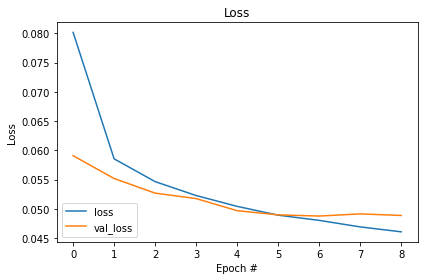

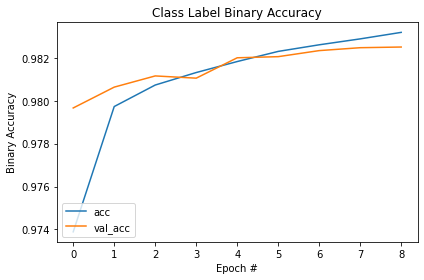

In [15]:
# Print result
train_acc = max(history.history['binary_accuracy'])
val_acc = max(history.history['val_binary_accuracy'])
print('Final training binary accuracy: %.4f' %train_acc)
print('Final validating binary accuracy: %.4f' %val_acc)

plt.figure()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.tight_layout()

plt.figure()
plt.plot(history.history["binary_accuracy"], label="acc")
plt.plot(history.history["val_binary_accuracy"], label="val_acc")
plt.title("Class Label Binary Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Binary Accuracy")
plt.legend(loc="lower left")
plt.tight_layout()

### Try to predict some comments

In [16]:
def predict_toxic(texts): 
    texts_cleaned = preprocessor.cleanse_corpus(texts)
        
    seqs = preprocessor.get_sequences_of_test_texts(texts_cleaned)
     
    # Prediction
    predicts = model.predict(seqs)
    return predicts.T

In [18]:
input_texts = ["Fuck yourself you son of a bitch", "I swear I'm gonna kill you", "I think that's fine"]

toxic, severe_toxic, obsence, threat, insult, identity_hate = predict_toxic(input_texts)

predictions = {}
predictions['Toxic score'] = toxic
predictions['Severe toxic score'] = severe_toxic
predictions['Obsence score'] = obsence
predictions['Threat score'] = threat
predictions['Insult score'] = insult
predictions['Identity hate score'] = identity_hate

for i in range(len(input_texts)):
    print('~'*100)
    print(f"\"{input_texts[i]}\":")
    for label, score in predictions.items():
        print(f"{label}: {score[i]:.4f}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"Fuck yourself you son of a bitch":
Toxic score: 0.9999
Severe toxic score: 0.5079
Obsence score: 0.9982
Threat score: 0.0082
Insult score: 0.9730
Identity hate score: 0.0556
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"I swear I'm gonna kill you":
Toxic score: 0.8318
Severe toxic score: 0.0465
Obsence score: 0.0729
Threat score: 0.7570
Insult score: 0.1698
Identity hate score: 0.0135
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"I think that's fine":
Toxic score: 0.0043
Severe toxic score: 0.0000
Obsence score: 0.0010
Threat score: 0.0000
Insult score: 0.0005
Identity hate score: 0.0001


### The trained model can be loaded from the disk

Load the model

In [19]:
from tensorflow.keras.models import load_model

In [20]:
model = load_model('./model/model_best.h5')

## Evaluate the model with test data

### Load and preprocess the test data

In [21]:
test_raw = pd.read_csv("./data/test.csv")
test_labels = pd.read_csv("./data/test_labels.csv")
test_raw = pd.merge(test_raw, test_labels, how='left', on='id')
test_raw = test_raw.drop(test_raw[test_raw['toxic']==-1].index)
test_raw.index = range(len(test_raw))

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_targets = test_raw[label_names].values

Take a look at the test data

In [22]:
print(test_raw.head())
print(len(test_targets))
print(test_raw['comment_text'])

                 id                                       comment_text  toxic  \
0  0001ea8717f6de06  Thank you for understanding. I think very high...      0   
1  000247e83dcc1211                   :Dear god this site is horrible.      0   
2  0002f87b16116a7f  "::: Somebody will invariably try to add Relig...      0   
3  0003e1cccfd5a40a  " \n\n It says it right there that it IS a typ...      0   
4  00059ace3e3e9a53  " \n\n == Before adding a new product to the l...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
63978
0        Thank you for understanding. I think very high...
1                         :Dear god this site is horrible.
2        "::: Somebody will invariably tr

Cleanse the data. 

This time we check how many tokens in the test data are covered by the train vocab before and after the cleansing.

In [23]:
print('-'*21 + '\n|Before cleansing...|\n' + '-'*21)
vocab_test = corpus_to_vocab(test_raw['comment_text'])
oov_words_text = embedding_coverage(vocab_test, preprocessor.word2idx)
print(f"oov word examples:\n{oov_words_text[:10]}")

print('-'*21 + '\n|Cleansing corpus...|\n' + '-'*21)
test = pd.DataFrame()
test['comment_text'] = preprocessor.cleanse_corpus(test_raw['comment_text'])

print('-'*20 + '\n|After cleansing...|\n' + '-'*20)
vocab_test = corpus_to_vocab(test['comment_text'])
oov_words_test = embedding_coverage(vocab_test, preprocessor.word2idx) 
print(f"oov word examples:\n{oov_words_text[:10]}")

---------------------
|Before cleansing...|
---------------------
Embeddings founded for 12.21% of vocab
Embeddings founded for 67.84% of all texts
oov word examples:
[('I', 58698), ('"', 33393), ('==', 31155), ('The', 14136), ('-', 9794), ('If', 8512), ("I'm", 6253), ('You', 6135), ('It', 5963), ('This', 5760)]
---------------------
|Cleansing corpus...|
---------------------
--------------------
|After cleansing...|
--------------------
Embeddings founded for 42.76% of vocab
Embeddings founded for 96.19% of all texts
oov word examples:
[('I', 58698), ('"', 33393), ('==', 31155), ('The', 14136), ('-', 9794), ('If', 8512), ("I'm", 6253), ('You', 6135), ('It', 5963), ('This', 5760)]


Get the sequences of test texts

In [24]:
seqs_test = preprocessor.get_sequences_of_test_texts(test['comment_text'])
print(len(seqs_test))

63978


### Evaluate the model by the test data

In [41]:
score = model.evaluate(np.array(seqs_test), np.array(test_targets))
print(f'Test loss: {score[0]: .4f}') 
print(f'Test binary accuracy: {score[1]: .4f}')

2000/2000 [==============================] - 20s 10ms/step - loss: 0.0686 - binary_accuracy: 0.9733
Test loss:  0.0686
Test binary accuracy:  0.9733


## Remark

Let's understand the metrics. The binary accuracy used to moniter and evaluate the model performance calculates the accuracy of the predictions for all entries (toxicity categories) of all data samples. This can be illustrated by the following simply example:

In [28]:
from keras.metrics import binary_accuracy

In [40]:
labels = np.array([[0, 1, 0, 1, 0, 0], [1, 1, 0, 0, 1, 1]], dtype='float32')
results = np.array([[0.1, 0.2, 0.9, 0.6, 0.6, 0.7], [0.8, 0.9, 0.1, 0.4, 0.7, 0.7]], dtype='float32')

print(tf.reduce_mean(binary_accuracy(labels, results)))

tf.Tensor(0.6666667, shape=(), dtype=float32)


Because we have 12 entries in total and 8 of them get predicted correctly, which leads to the result of 8/12 = 0.6666667.

This is a quite harsh metrics to use. Nonetheless, our rather simple model achieved 0.9733 on the test data, which is quite good. Other metrics may be preferred according to the purpose of the specific task. Also, further achitecture and hyperparameter tuning could possibly lead to better results.